<a href="https://colab.research.google.com/github/TomGervers/arXiv_astro_ML/blob/main/arXiv_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download and prepare the dataset

Install the Kaggle api.

In [1]:
!pip install -q kaggle

This will prompt the user to upload a file. The file uploaded should be the kaggle.json file containing information about their Kaggle API key, this is available under the API heading at: https://www.kaggle.com/settings/account

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tomgeeee","key":"9b00fb8914de3d63b6eb34bbfbd21ce5"}'}

Remove if exists and then create a Kaggle folder which the kaggle.json file is then moved to.

In [3]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


Download the arXiv dataset from Kaggle.

In [4]:
!kaggle datasets download -d Cornell-University/arxiv

 99% 1.17G/1.18G [00:16<00:00, 83.4MB/s]
100% 1.18G/1.18G [00:16<00:00, 75.8MB/s]


Remove if exists and then create a dataset folder which the arXiv dataset is unzipped into.

In [5]:
!rm -r dataset
!mkdir dataset

!unzip arxiv.zip -d dataset

rm: cannot remove 'dataset': No such file or directory
Archive:  arxiv.zip
  inflating: dataset/arxiv-metadata-oai-snapshot.json  


---------------------------------------------------------------------------------------------------

# Read the dataset, extracting any papers categorised with any astrophysics tags

Defining imports.

In [6]:
import pandas as pd
import numpy as np
import json
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import re
import sys

Installing and importing pylatexnc, a package that allows for the easy conversion from latex to UTF.

In [ ]:
!pip install -q pylatexenc
from pylatexenc.latex2text import LatexNodes2Text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


Defining the arXiv astro-ph categories.

In [7]:
category_map = {'astro-ph': 'Astrophysics',
'astro-ph.CO': 'Cosmology and Nongalactic Astrophysics',
'astro-ph.EP': 'Earth and Planetary Astrophysics',
'astro-ph.GA': 'Astrophysics of Galaxies',
'astro-ph.HE': 'High Energy Astrophysical Phenomena',
'astro-ph.IM': 'Instrumentation and Methods for Astrophysics',
'astro-ph.SR': 'Solar and Stellar Astrophysics'
}

category_ids = ['astro-ph', 'astro-ph.CO', 'astro-ph.EP', 'astro-ph.GA', 'astro-ph.HE', 'astro-ph.IM', 'astro-ph.SR']

Defining a function that splits the string containing the authors names into a list of authors.

In [8]:
def get_clean_authors(authors):
    r = []
    for a in authors:
        r.append(" ".join(a).strip())
    return r

Reading the dataset JSON and processing it, extracting the information desired on each line and returning it as a pandas dataframe.

In [9]:
cols = ['id', 'clean_authors', 'title', 'abstract', 'versions', 'categories_list']
papers = []
with open("dataset/arxiv-metadata-oai-snapshot.json", "r") as f:
    for l in f:
        d = json.loads(l)
        if any(x in category_ids for x in d['categories'].split(' ')):
            d['clean_authors'] = get_clean_authors(d['authors_parsed'])
            list = [d['id'], d['clean_authors'], d['title'], d['abstract'], d['versions'], d['categories'].split(' ')]
            papers.append(list)

papers_df = pd.DataFrame().from_records(papers, columns=cols)
papers_df['created_datetime'] = [datetime.datetime.strptime(date[0]['created'].split(',')[1],' %d %b %Y %H:%M:%S %Z') for date in papers_df['versions']]
papers_df['year'] = papers_df['created_datetime'].dt.year

Save the dataframe containing the papers as a CSV file if desired.

In [ ]:
#papers_df.to_csv("papers_df.csv")

----------------------------------------------------------------------------------------------------------------------------------------------------------------

# Extract papers which involve machine learning

Remove newline (\n) characters from the papers abstracts.

In [10]:
papers_df[['abstract']] = papers_df[['abstract']].replace(r'\n',' ', regex=True)

Define the words/phrases for each wave and the overall list

In [11]:
wave1 = ['perceptron', 'multilayer perceptron', 'multi-layer perceptron', 'multi layer perceptron', 'artificial neuron', 'artificial neural network', 'artificial neural', 'artificial neural-network', 'backpropagation']
wave2 = ['Convolutional Neural', 'convolutional neural network', 'convolutional neural-network', 'Recurrent Neural', 'Recurrent neural network', 'Recurrent neural-network', 'convolutional layer', 'pooling layer',
         'LSTM', 'long short-term memory', 'long short term memory', 'long short-term', 'long short term', 'gated recurrent', 'gated-recurrent', 'residual network', 'transformer',' transformers', 'transformer model',
         'self-attention', 'self attention', 'supervised learning', 'supervised deep learning', 'supervised deep-learning']
wave3 = ['deep generative modelling', 'deep generative-modelling', 'deep generative', 'generative modelling', 'generative', 'GAN', 'generative adversarial', 'autoencoder', 'auto-encoder', 'variational autoencoder',
         'variational auto-encoder', 'diffusion model', 'score-based model', 'score based model', 'score-based  generative model', 'score based generative model', 'competing neural', 'competing neural-networks',
         'representation learning', 'self-supervised', 'self supervised', 'contrastive learning', 'learning representations', 'surrogate task', 'word embedding', 'word-embedding']

phrases = ['Artificial Intelligence', 'Machine Learning','LLMS','Large Language Models', 'Neural Network', 'Neural Networks', 'support vector machine', 'support vector', 'deep learning', 'deep-learning']

Defining the regex search function that searches each abstract for the phrases in the list.

In [12]:
def contains_phrase(row,phrases):
    for phrase in phrases:
        if re.search(r'\b' + phrase + r'\b', row, re.IGNORECASE):
            return True
    return False

Extract the papers that contain the search phrases

In [13]:
wave1_df = papers_df[papers_df['abstract'].apply(contains_phrase, args=(wave1,))]
wave2_df = papers_df[papers_df['abstract'].apply(contains_phrase, args=(wave2,))]
wave3_df = papers_df[papers_df['abstract'].apply(contains_phrase, args=(wave3,))]
phrases_temp_df = papers_df[papers_df['abstract'].apply(contains_phrase, args=(phrases,))]

frames = [wave1_df, wave2_df, wave3_df, phrases_temp_df]
phrases_df = pd.concat(frames)
phrases_df.drop_duplicates(subset=['id'],inplace=True)

In [ ]:
# LaTex to UTF
clean_abstract = []
clean_title = []
for i,a in phrases_df.iterrows():

    # Clean title
    try:
        clean_title.append(LatexNodes2Text().latex_to_text(a['title']).replace('\n', ' ').strip())
    except:
        clean_title.append(a['title'].replace('\n', ' ').strip())

    # Clean abstract
    try:
        clean_abstract.append(LatexNodes2Text().latex_to_text(a['abstract']).replace('\n', ' ').strip())
    except:
        clean_abstract.append(a['abstract'].replace('\n', ' ').strip())
phrases_df['clean_abstracts'] = clean_abstract
phrases_df['clean_title'] = clean_title
clean_abstract = ''
clean_title = ''

# Using TF-IDF and a Support Vector Machine to attempt to classify papers

In [14]:
import string
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
# Preprocessing and tokenizing
def preprocessing(line):
    line = line.lower()
    line = re.sub(r'\b\w{1,3}\b', '', line)
    line = re.sub(r"[{}]".format(string.punctuation), " ", line)
    line = line.replace('\\', '')
    line = line.translate({ord(k): None for k in string.digits})
    line = " ".join([i for i in word_tokenize(line) if i not in stop_words])
    return line

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

In [17]:
non_ml_df = pd.concat([papers_df, phrases_df, phrases_df]).drop_duplicates(subset=['id'], keep=False)

In [18]:
whole_df = pd.concat([phrases_df.sample(1000), non_ml_df.sample(4000)])

whole_df['target'] = ((['ML']*(1000)) + (['Non-ML']*(4000)))

whole_df.drop_duplicates(subset=['id'],inplace=True)

whole_train = pd.DataFrame()
whole_test = pd.DataFrame()

whole_train['data'], whole_test['data'], whole_train['target'], whole_test['target'] = train_test_split(whole_df['abstract'], whole_df['target'], stratify=whole_df['target'], test_size=0.2)

whole_df = ''

In [ ]:
X = whole_train.data
y = whole_train.target
y.replace(to_replace=['Non-ML', 'ML'], value=[-1, 1], inplace=True)

count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(X)
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)

In [19]:
processed = []
for df in [whole_train, whole_test]:

    for i,a in df.iterrows():
        processed.append(preprocessing(a['data']))
    df['data'] = processed

    processed = []

In [ ]:
text_clf_SGD = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                          alpha=1e-3, random_state=42,
                          max_iter=5, tol=None)),
])

In [ ]:
from sklearn.ensemble import RandomForestClassifier
text_clf_RFC = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier()),
])

In [ ]:
text_clf_SGD.fit(whole_train.data, whole_train.target)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                               tol=None))])

In [ ]:
text_clf_RFC.fit(whole_train.data, whole_train.target)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier())])

In [20]:
from sklearn.svm import SVC
text_clf_BSVM = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SVC(kernel='linear', class_weight='balanced')),
])

In [21]:
text_clf_BSVM.fit(whole_train.data, whole_train.target)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', SVC(class_weight='balanced', kernel='linear'))])

In [22]:
preprocessed = []

for i,a in papers_df.iterrows():
        preprocessed.append(preprocessing(a.abstract))

papers_df['preprocessed'] = preprocessed
preprocessed = ''

In [23]:
papers_df.to_csv('papers_df.csv')
phrases_df.to_csv('phrases_df.csv')

In [ ]:
papers_df['predicted'] = text_clf_SGD.predict(papers_df.preprocessed)

In [ ]:
papers_df['predicted'] = text_clf_RFC.predict(papers_df.preprocessed)

In [ ]:
len(phrases_df)

3856

In [ ]:
papers_df.predicted.value_counts()

AttributeError: ignored

In [ ]:
rf_papers_df = papers_df.loc[papers_df['predicted']=='ML']

In [ ]:
rf_papers_df.to_csv('rf_ml.csv')

In [24]:
papers_df['predicted'] = text_clf_BSVM.predict(papers_df.preprocessed)

In [25]:
biasSVM_papers_df = rf_papers_df = papers_df.loc[papers_df['predicted']=='ML']

In [26]:
from sklearn.metrics import accuracy_score

In [27]:
accuracy_score(whole_test.target, text_clf_BSVM.predict(whole_test.data))

0.958

In [28]:
from sklearn.metrics import balanced_accuracy_score

In [29]:
balanced_accuracy_score(whole_test.target, text_clf_BSVM.predict(whole_test.data))

0.923125

In [30]:
from sklearn.metrics import classification_report

In [31]:
print(classification_report(whole_test.target, text_clf_BSVM.predict(whole_test.data), target_names=['ML', 'Non-ML']))

              precision    recall  f1-score   support

          ML       0.92      0.86      0.89       200
      Non-ML       0.97      0.98      0.97       800

    accuracy                           0.96      1000
   macro avg       0.94      0.92      0.93      1000
weighted avg       0.96      0.96      0.96      1000



In [32]:
biasSVM_papers_df.to_csv('biasSVM_ml.csv')

In [33]:
biasSVM_papers_df.abstract.iloc[100]

"  This paper provides an evaluation of SGI RASCTM RC100 technology from a computational science software developer's perspective. A brute force implementation of a two-point angular correlation function is used as a test case application. The computational kernel of this test case algorithm is ported to the Mitrion-C programming language and compiled, targeting the RC100 hardware. We explore several code optimization techniques and report performance results for different designs. We conclude the paper with an analysis of this system based on our observations while implementing the test case. Overall, the hardware platform and software development tools were found to be satisfactory for accelerating computationally intensive applications, however, several system improvements are desirable. "

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(whole_test.target, text_clf_BSVM.predict(whole_test.data), labels=['ML', 'Non-ML'])

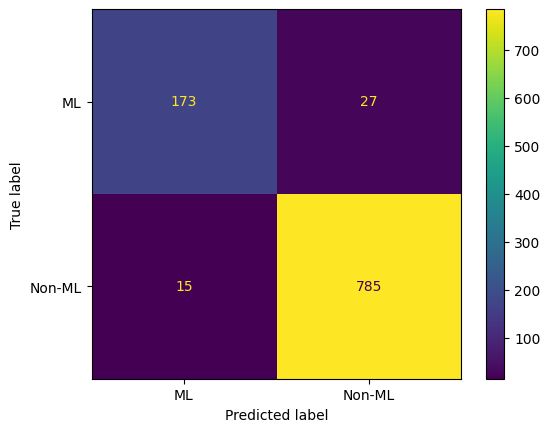

In [35]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['ML', 'Non-ML'])
disp.plot()

plt.show()

In [36]:
whole_test['prediction'] = text_clf_BSVM.predict(whole_test.data)

In [37]:
fp = whole_test[(whole_test.prediction == 'ML') & (whole_test.target == 'Non-ML')]
fn = whole_test[(whole_test.prediction == 'Non-ML') & (whole_test.target == 'ML')]

In [38]:
fp.to_csv('fp.csv')
fn.to_csv('fn.csv')

In [39]:
fp_full = papers_df[papers_df.index.isin(fp.index)]
fn_full = papers_df[papers_df.index.isin(fn.index)]

In [40]:
fp_full.to_csv('fp_full.csv')
fn_full.to_csv('fn_full.csv')

-------------------------------------------------------

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
sgdc_params = {
    'clf__loss':['hinge', 'squared_hinge'],
    'clf__penalty':['l2', 'l1', 'elasticnet', 'None'],
    'clf__alpha':np.logspace(1e-8, 10, 50),
}

In [ ]:
gs_clf = GridSearchCV(text_clf_SGD, sgdc_params, cv=5, n_jobs=-1)

In [ ]:
gs_clf = gs_clf.fit(whole_train.data[:400], whole_test.target[:400])

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
500 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
248 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py", line 891, in fit
    self._validate_params()
  File "/usr/local/lib/p

In [ ]:
gs_clf.best_score_
for param_name in sorted(sgdc_params.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

clf__alpha: 1.000002302587744
clf__loss: 'hinge'
clf__penalty: 'l2'


------------------------------------------------------------------------

# Hypothesis testing

In [ ]:
years = test_df['year'].unique()
years.sort()

In [ ]:
im_dict = {}
ga_dict = {}
co_dict = {}
sr_dict = {}
he_dict = {}
ep_dict = {}
ph_dict = {}

for j in years:
    temp_df = test_df.loc[test_df['year'] == j]
    for i in temp_df.categories_list:
        if i == 'astro-ph.IM':
            im_dict.setdefault(j, 0)
            im_dict[j] += 1
        elif i == 'astro-ph.GA':
            ga_dict.setdefault(j, 0)
            ga_dict[j] += 1
        elif i == 'astro-ph.CO':
            co_dict.setdefault(j, 0)
            co_dict[j] += 1
        elif i == 'astro-ph.SR':
            sr_dict.setdefault(j, 0)
            sr_dict[j] += 1
        elif i == 'astro-ph.HE':
            he_dict.setdefault(j, 0)
            he_dict[j] += 1
        elif i == 'astro-ph.EP':
            ep_dict.setdefault(j, 0)
            ep_dict[j] += 1
        elif i == 'astro-ph':
            ph_dict.setdefault(j, 0)
            ph_dict[j] += 1

In [ ]:
ph_dict.values()

dict_values([1, 6, 9, 12, 9, 9, 13, 10, 19, 19, 20, 17, 25, 22, 29, 32])

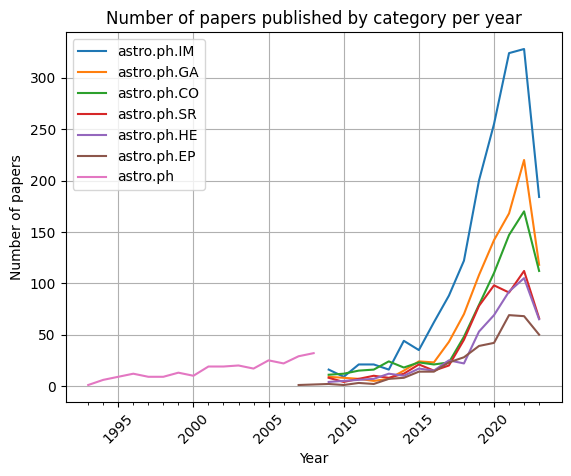

In [ ]:
plt.plot(im_dict.keys(), im_dict.values(), label='astro.ph.IM')
plt.plot(ga_dict.keys(), ga_dict.values(), label='astro.ph.GA')
plt.plot(co_dict.keys(), co_dict.values(), label='astro.ph.CO')
plt.plot(sr_dict.keys(), sr_dict.values(), label='astro.ph.SR')
plt.plot(he_dict.keys(), he_dict.values(), label='astro.ph.HE')
plt.plot(ep_dict.keys(), ep_dict.values(), label='astro.ph.EP')
plt.plot(ph_dict.keys(), ph_dict.values(), label='astro.ph')
plt.xticks(rotation = 45)
plt.xticks(years, minor=True)

plt.title('Number of papers published by category per year')
plt.xlabel('Year')
plt.ylabel('Number of papers')

plt.legend()
plt.grid()
plt.show()

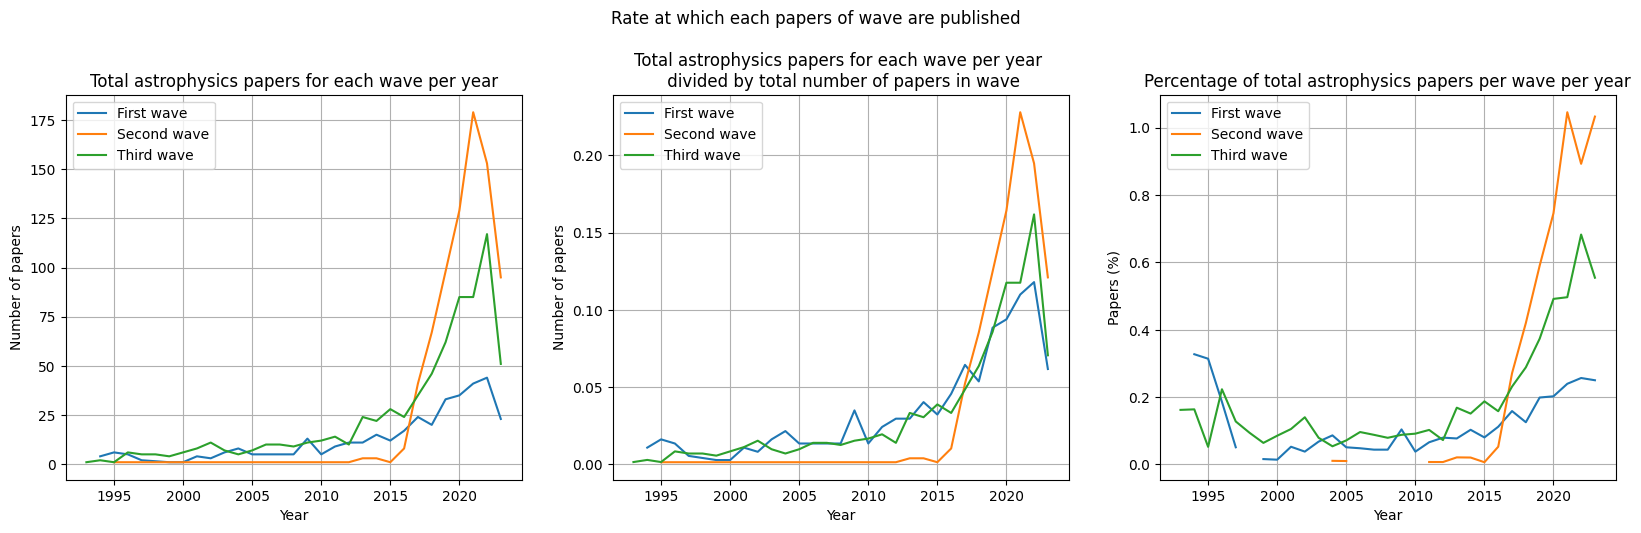

In [ ]:
fig, axs = plt.subplots(1, 3, figsize = (20,5))
axs[0].plot(wave1_df['year'].value_counts().sort_index(), label = 'First wave')
axs[0].plot(wave2_df['year'].value_counts().sort_index(), label = 'Second wave')
axs[0].plot(wave3_df['year'].value_counts().sort_index(), label = 'Third wave')
axs[0].legend()
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Number of papers')
axs[0].set_title('Total astrophysics papers for each wave per year')
axs[0].grid()

axs[1].plot(wave1_df['year'].value_counts().sort_index()/wave1_df['year'].count(), label = 'First wave')
axs[1].plot(wave2_df['year'].value_counts().sort_index()/wave2_df['year'].count(), label = 'Second wave')
axs[1].plot(wave3_df['year'].value_counts().sort_index()/wave3_df['year'].count(), label = 'Third wave')
axs[1].legend()
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Number of papers')
axs[1].set_title('Total astrophysics papers for each wave per year \n divided by total number of papers in wave')
axs[1].grid()

axs[2].plot((wave1_df['year'].value_counts().sort_index()/papers_df['year'].value_counts().sort_index())*100, label = 'First wave')
axs[2].plot((wave2_df['year'].value_counts().sort_index()/papers_df['year'].value_counts().sort_index())*100, label = 'Second wave')
axs[2].plot((wave3_df['year'].value_counts().sort_index()/papers_df['year'].value_counts().sort_index())*100, label = 'Third wave')
axs[2].legend()
axs[2].set_xlabel('Year')
axs[2].set_ylabel('Papers (%)')
axs[2].set_title('Percentage of total astrophysics papers per wave per year')
axs[2].grid()

fig.suptitle('Rate at which each papers of wave are published', y=1.05)

plt.show()

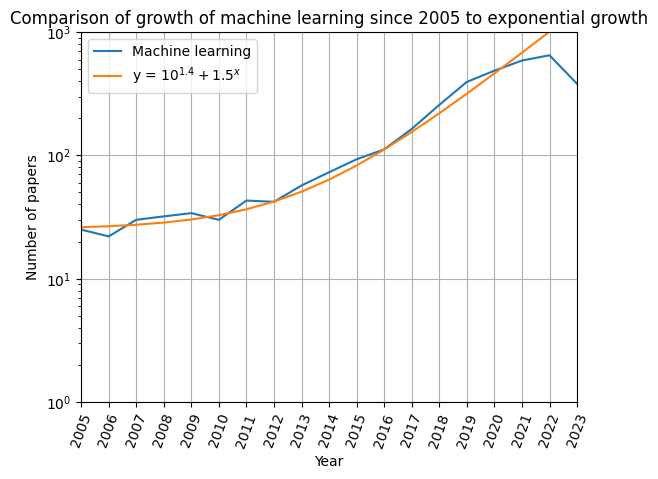

In [ ]:
x = np.arange(0, 19, 1,dtype=int)
#y = (10**1.5) + 1 * np.exp(0.4 * x)
y = (1.5**x) + (10**1.4)

plt.plot(phrases_df['year'].value_counts().sort_index(), label = 'Machine learning')


#plt.plot(x+2005, y, label = 'y = $e^{(0.4x)}$')
plt.plot(x+2005, y, label = 'y = $10^{1.4} + 1.5^{x}$')
plt.legend()
plt.xlabel('Year')

plt.yscale('log', base=10)
plt.ylim(1, 1000)
plt.xlim(2005, 2023)

plt.xticks(np.arange(2005,2024,1), rotation=70)


plt.ylabel('Number of papers')
plt.title('Comparison of growth of machine learning since 2005 to exponential growth')
plt.grid()
plt.show()

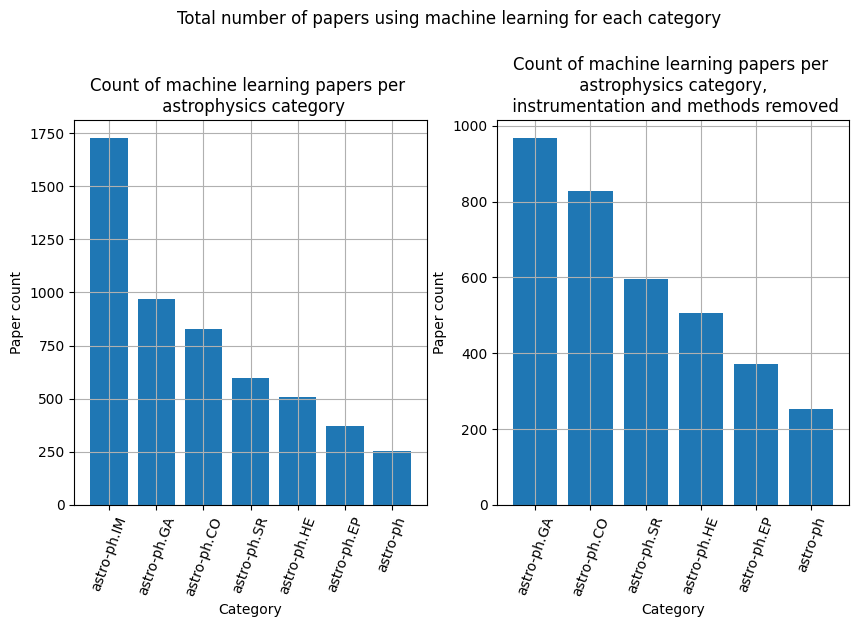

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (10,5))

phrase_cat_df = phrases_df.explode('categories_list')

cat_dict = {}

for i in range(len(phrase_cat_df['categories_list'].value_counts().tolist())):
    if phrase_cat_df['categories_list'].value_counts().index.tolist()[i] in category_ids:
        cat_dict[phrase_cat_df['categories_list'].value_counts().index.tolist()[i]] = phrase_cat_df['categories_list'].value_counts().tolist()[i]

axs[0].bar(range(len(cat_dict)), list(cat_dict.values()), align='center')
axs[0].set_xticks(range(len(cat_dict)), list(cat_dict.keys()), rotation=70)
axs[0].set_xlabel('Category')
axs[0].set_ylabel('Paper count')
axs[0].set_title('Count of machine learning papers per \n astrophysics category')
axs[0].grid()


phrase_cat_df_noim = phrase_cat_df[phrase_cat_df["categories_list"] != "astro-ph.IM"]
cat_dict = {}

for i in range(len(phrase_cat_df_noim['categories_list'].value_counts().tolist())):
    if phrase_cat_df_noim['categories_list'].value_counts().index.tolist()[i] in category_ids:
        cat_dict[phrase_cat_df_noim['categories_list'].value_counts().index.tolist()[i]] = phrase_cat_df_noim['categories_list'].value_counts().tolist()[i]

plt.bar(range(len(cat_dict)), list(cat_dict.values()), align='center')
axs[1].set_xticks(range(len(cat_dict)), list(cat_dict.keys()), rotation=70)
axs[1].set_xlabel('Category')
axs[1].set_ylabel('Paper count')
axs[1].set_title('Count of machine learning papers per \n astrophysics category, \n instrumentation and methods removed')
axs[1].grid()

fig.suptitle('Total number of papers using machine learning for each category', y=1.10)

plt.show()

-----------------------------------------------------------------------------------------------------------------------------

# Comparing the number of authors on high and low impact papers

In [ ]:
!pip install ads

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ads: filename=ads-0.12.3-py3-none-any.whl size=37376 sha256=5fa412a2d5f1821d450f0a2427595e885326c9c329761bee3029f20e330d8df4
  Stored in directory: /root/.cache/pip/wheels/f6/58/3a/89f967413ce40834546a8461de8b735d9f24c5f520802188d2
  Created wheel for httpretty: filename=httpretty-0.8.10-py3-none-any.whl size=23998 sha256=2f09c8533ddd14302dddc68a3dab26d63c1fe8953e9e0678e481a3508cc52ef5
  Stored in directory: /root/.cache/pip/wheels/fc/5d/09/2ab9bcf3f2bdd57a4be12cc5868c304ef1f4953292022ff9e7
Successfully built ads httpretty


In [ ]:
#import ads.sandbox as ads
import ads

In [ ]:
ads.config.token = 'DwfLcfka8BjXmNvfiGqzyyqLiR3nK8D7E5ZbXplt'
papers = ads.SearchQuery(q="Photo-z for weak lensing tomography from space: the role of optical and near-IR photometry", sort="citation_count")
for paper in papers:
    print(paper.title)

['Photometric redshifts for weak lensing tomography from space: the role of optical and near infrared photometry']


In [ ]:
q = ads.SearchQuery(q=phrases_df.title.iloc[1], fl=['id', 'bibcode', 'title', 'citation_count'])
for paper in q:
    print(str(paper.title), paper.citation_count)

In [ ]:
r = ads.RateLimits('SearchQuery')
q = ads.SearchQuery(q="Photo-z for weak lensing tomography from space: the role of optical and near-IR photometry", sort="citation_count")
for paper in q:
    print(paper.title)
r.limits

In [ ]:
ads_df = phrases_df.sample(frac=0.01)

In [ ]:
ads.config.token = 'DwfLcfka8BjXmNvfiGqzyyqLiR3nK8D7E5ZbXplt'

failed_search=[]
query_res = []
query_title = []
for index, row in ads_df.iterrows():
    try:
        q = list(ads.SearchQuery(q=row['clean_title'], fl=['citation_count']))
        #for paper in q:
        query_res.append(q[0].citation_count)
        query_title.append(row['clean_title'])
        #print(q[0].citation_count)
    except:
        failed_search.append(row['clean_title'])

In [ ]:
citation_df = pd.DataFrame(query_res, columns = ['citations'])
citation_df['title'] = query_title
ads_cite_df = ads_df.merge(citation_df, how='left', left_on='clean_title', right_on='title')
del[ads_cite_df['title_y']]

In [ ]:
ads_cite_df.sort_values(by=['citations'], ascending=False, inplace=True)

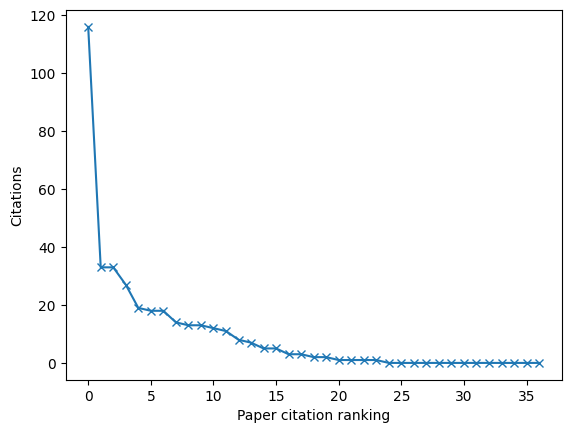

In [ ]:
plt.plot(range(len(ads_cite_df)),ads_cite_df.citations.fillna(0), marker='x', markersize=6)
plt.xlabel('Paper citation ranking')
plt.ylabel('Citations')
plt.show()

In [ ]:
print('Entry in NASA ADS could not be found for {}% of papers'.format(round(((len(failed_search)/len(ads_cite_df))*100),2)))

Entry in NASA ADS could not be found for 13.51% of papers


In [ ]:
n = 10 #Percentage considered high impact
high_impact_df = ads_cite_df.head(int(len(ads_cite_df)*(n/100)))

In [ ]:
low_impact_df = pd.concat([ads_cite_df,high_impact_df]).drop_duplicates(keep=False, subset=['id'])

In [ ]:
high_impact_df['clean_authors'].str.len().agg(['mean','max','std','median'])

mean      5.000000
max       7.000000
std       2.645751
median    6.000000
Name: clean_authors, dtype: float64

In [ ]:
low_impact_df['clean_authors'].str.len().agg(['mean','max','std','median'])

mean       6.235294
max       30.000000
std        6.813795
median     4.000000
Name: clean_authors, dtype: float64

In [ ]:
papers_sample_df = papers_df.sample(frac=0.01)

In [ ]:
ads.config.token = 'DwfLcfka8BjXmNvfiGqzyyqLiR3nK8D7E5ZbXplt'

failed_search=[]
query_res = []
query_title = []
for index, row in papers_sample_df.iterrows():
    try:
        q = list(ads.SearchQuery(q=row['title'], fl=['citation_count']))
        #for paper in q:
        query_res.append(q[0].citation_count)
        query_title.append(row['title'])
        #print(q[0].citation_count)
    except:
        failed_search.append(row['title'])

In [ ]:
paper_citation_df = pd.DataFrame(query_res, columns = ['citations'])
paper_citation_df['title'] = query_title
paper_ads_cite_df = papers_sample_df.merge(paper_citation_df, how='left', left_on='title', right_on='title')
#del[paper_ads_cite_df['title_y']]

In [ ]:
paper_ads_cite_df.sort_values(by=['citations'], ascending=False, inplace=True)

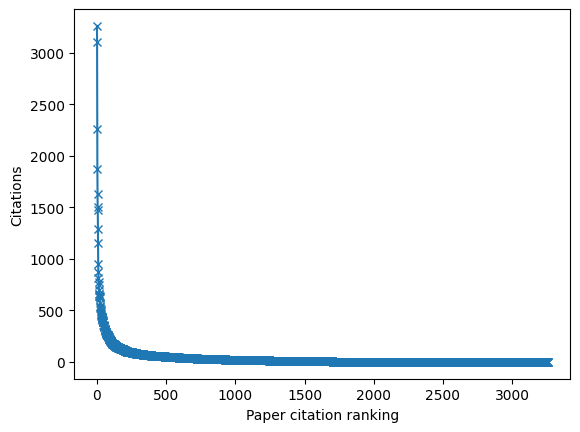

In [ ]:
plt.plot(range(len(paper_ads_cite_df)),paper_ads_cite_df.citations.fillna(0), marker='x', markersize=6)
plt.xlabel('Paper citation ranking')
plt.ylabel('Citations')
plt.show()

In [ ]:
print('Entry in NASA ADS could not be found for {}% of papers'.format(round(((len(failed_search)/len(paper_ads_cite_df))*100),2)))

Entry in NASA ADS could not be found for 29.09% of papers


In [ ]:
n = 10 #Percentage considered high impact
high_impact_df = ads_cite_df.head(int(len(paper_ads_cite_df)*(n/100)))
low_impact_df = pd.concat([paper_ads_cite_df,high_impact_df]).drop_duplicates(keep=False, subset=['id'])

In [ ]:
high_impact_df['clean_authors'].str.len().agg(['mean','max','std','median'])

mean       6.135135
max       30.000000
std        6.562360
median     4.000000
Name: clean_authors, dtype: float64

In [ ]:
low_impact_df['clean_authors'].str.len().agg(['mean','max','std','median'])

mean         7.360437
max       1253.000000
std         34.022834
median       3.000000
Name: clean_authors, dtype: float64

--------------------------------------------------------------------------------------------------------------------